### Import libraries

In [230]:
#Import libraries to be used
import os
import pandas as pd
import tensorflow as tf
import glob
import copy
import re
import string
import matplotlib.pyplot as plt
from collections import Counter

# To remove stopwords from text
from nltk.corpus import stopwords
stoplist = set(stopwords.words("english"))

# To finetune BERT model on custom dataset
from transformers import BertTokenizer, TFBertForSequenceClassification

# For Wordcloud visualisation
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

### Import .txt files to create dataset

In [2]:
# Absolute path to parse text files in the folder
text_path = r'D:\Coding\Twitter_Sentimental_Analysis\Training_Data/*.txt'
text_files = glob.glob(text_path)

### Create dataframe from Text files

In [126]:
# Create a dictionary and loop all text files as dataframes into it
text_dictionary = {}

for index, file in enumerate(text_files):
    temp_df = pd.read_csv(text_files[index], delimiter = "\t", header = None)
    text_dictionary[index] = temp_df

In [127]:
# Create the dataframe containing text to classify and its sentiment
data_dataframe = pd.DataFrame(columns=['Sentiment', 'Text'])

# Loop through all dataframes, and only take the columns with sentiment and text
# Sentiment word list
sentiment_word_list = ['neutral', 'negative', '-1', 'positive', '0', '1']

for current_df in range(len(text_dictionary)):
    for index, value in enumerate(text_dictionary[current_df].iloc[0,:]):
        if str(value) in sentiment_word_list:

            # Create temporary Dataframe with the two columns (sentiment and text)
            temp_df = pd.DataFrame({'Sentiment': text_dictionary[current_df].iloc[:,index], 'Text': text_dictionary[current_df].iloc[:,index+1]})

            # Append the temporary DataFrame to the original Dataframe
            data_dataframe = data_dataframe.append(temp_df, ignore_index = True)

C:\Users\amito\AppData\Local\Temp\ipykernel_11376\1772446728.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_dataframe = data_dataframe.append(temp_df, ignore_index = True)


In [128]:
# Define the mapping dictionary for sentiment values
sentiment_mapping = {
    'positive': 1,
    'negative': -1,
    2: 1,
    -2: -1,
}

# Convert sentiment values using the mapping dictionary
data_dataframe = data_dataframe.replace({"Sentiment": sentiment_mapping})

# Drop rows with neutral or off-topic sentiment
data_dataframe = data_dataframe[~data_dataframe['Sentiment'].isin(['neutral', 0, 'off topic'])]

# Sort dataframe via the 'Sentiment column
data_dataframe = data_dataframe.sort_values(by=['Sentiment']).reset_index().drop(columns = ['index'])

### Balance dataset before pre-processing from training

In [131]:
# Current balance of sentiments
data_dataframe['Sentiment'].value_counts()

 1    71986
-1    23420
Name: Sentiment, dtype: int64

In [132]:
#Only copy equal datapoints
balanced_data_dataframe = copy.deepcopy(data_dataframe[0:23420*2])
balanced_data_dataframe['Sentiment'].value_counts()

-1    23420
 1    23420
Name: Sentiment, dtype: int64

### Preprocess text before saving into .csv file

In [133]:
# Preprocess text and remove punctuation, stopwords and whitespace
def preprocess_text(text):
    # Remove http / https links
    text = re.sub(r'http\S+|https\S+', '', text)
    # Convert to lowercase
    text = text.lower()
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    # Remove stopwords
    text = ' '.join(word for word in text.split() if word not in stoplist)
    # Remove extra whitespaces
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Convert -1 to 0 ---> for binary classification
def preprocess_sentiment(text):
    if text == -1:
        text = 0
    return text

In [134]:
# Apply the pre-processing techniques to both the columns
balanced_data_dataframe['Text'] = balanced_data_dataframe['Text'].apply(preprocess_text)
balanced_data_dataframe['Sentiment'] = balanced_data_dataframe['Sentiment'].apply(preprocess_sentiment)

In [136]:
# # Save the DataFrame as a CSV file for viewing
# balanced_data_dataframe.to_csv('balanced_train_df.csv', sep=' ', index=False)

# # Load saved CSV into DataFrame
# balanced_data_dataframe = pd.read_csv('balanced_train_df.csv', sep = ' ')

### Visual Data Analysis

In [143]:
print(f'Total Positive Sentiment texts: {balanced_data_dataframe["Sentiment"].value_counts()[1]} and Negative texts: {balanced_data_dataframe["Sentiment"].value_counts()[0]}')

Total Positive Sentiment texts: 23420 and Negative texts: 23420


### Plotting Wordcloud

In [235]:
# Function to remove '&amp' from text
def remove_amp(string):
    # Use regex with word boundaries to match 'amp' as a standalone word
    pattern = r'\bamp\b'
    # Replace 'amp' with an empty string
    modified_string = re.sub(pattern, '', string)
    return modified_string

# Function to plot Wordcloud from input string
def plot_wordcloud(string, title=''):
    #Create and generate wordcloud image
    wordcloud = WordCloud(width=1920, height=1080).generate(string)
    plt.figure(figsize=(20,10))
    plt.axis('off')
    plt.title(f"{title} Words Wordcloud")
    plt.imshow(wordcloud)

# Function to plot word frequency per input string
def plot_word_frequency(string, input_title=''):
    # Split the string into a list of words
    words = string.split()
    # Count the frequency of each word
    word_counts = Counter(words)
    # Get the top 10 most frequent words and their corresponding frequencies
    top_words = []
    frequencies = []
    for word, count in word_counts.most_common(10):
        top_words.append(word)
        frequencies.append(count)
    # Create a bar plot
    plt.bar(top_words, frequencies)
    plt.xlabel('Words')
    plt.ylabel('Frequency')
    plt.title(f'Top 10 {input_title} Words Frequency')
    plt.xticks(rotation=45)
    # Display the plot
    plt.show()

In [220]:
# Compile all positive and negative strings
all_negative_text = " ".join(text for text in balanced_data_dataframe['Text'][0:23420])
all_positive_text = " ".join(text for text in balanced_data_dataframe['Text'][23420:])

# Remove '&amp' from text using defined function
all_negative_text = remove_amp(all_negative_text)
all_positive_text = remove_amp(all_positive_text)

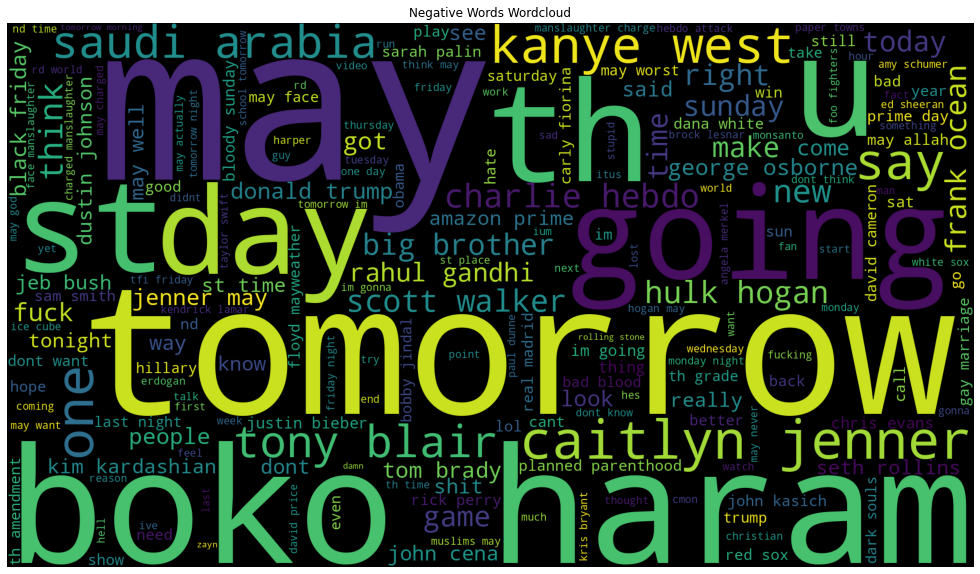

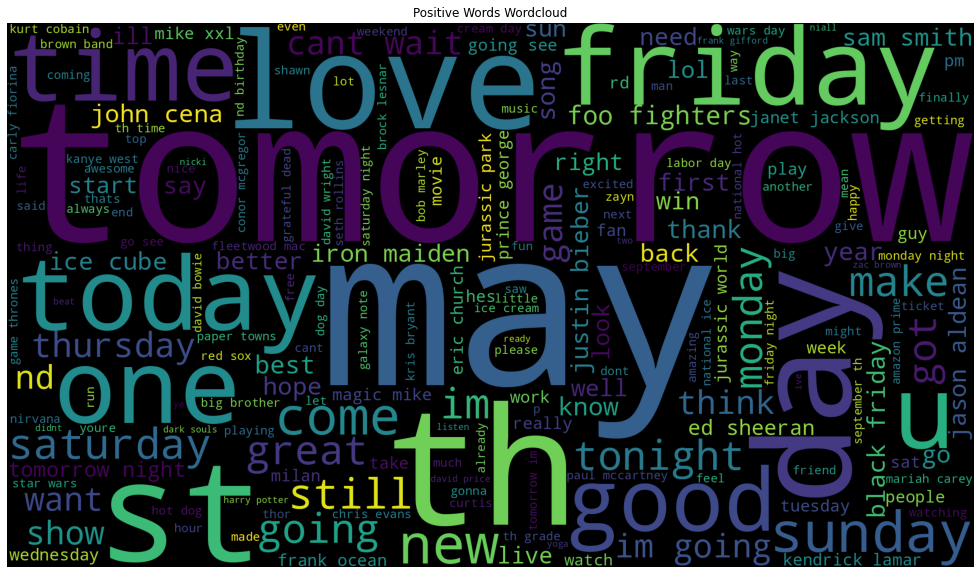

In [234]:
plot_wordcloud(all_negative_text, 'Negative')
plot_wordcloud(all_positive_text, 'Positive')

### Testing Word frequency count plotter

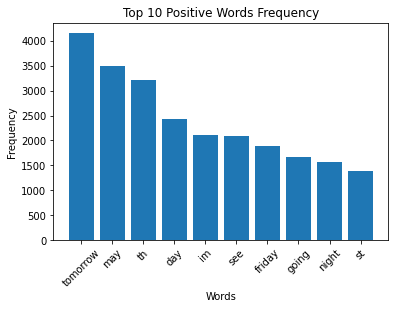

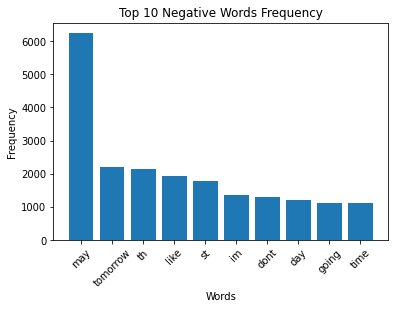

In [236]:
plot_word_frequency(all_positive_text,'Positive')
plot_word_frequency(all_negative_text,'Negative')